<font size="+3"><strong> Predicting with Logistic Regression</strong></font>

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Define the path
path = "/mnt/data/extracted_files"

# List extracted files
files = os.listdir(path)
print("Files:", files)

Files: ['dictionary.txt', 'tic.data.html', 'tic.html', 'tic.tar.gz', 'tic.task.html', 'ticdata2000.txt', 'TicDataDescr.txt', 'ticeval2000.txt', 'tictgts2000.txt']


In [3]:
column_names = [
    "MOSTYPE", "MAANTHUI", "MGEMOMV", "MGEMLEEF", "MOSHOOFD", "MGODRK", "MGODPR", "MGODOV", "MGODGE",
    "MRELGE", "MRELSA", "MRELOV", "MFALLEEN", "MFGEKIND", "MFWEKIND", "MOPLHOOG", "MOPLMIDD", "MOPLLAAG",
    "MBERHOOG", "MBERZELF", "MBERBOER", "MBERMIDD", "MBERARBG", "MBERARBO", "MSKA", "MSKB1", "MSKB2",
    "MSKC", "MSKD", "MHHUUR", "MHKOOP", "MAUT1", "MAUT2", "MAUT0", "MZFONDS", "MZPART", "MINKM30",
    "MINK3045", "MINK4575", "MINK7512", "MINK123M", "MINKGEM", "MKOOPKLA", "PWAPART", "PWABEDR", "PWALAND",
    "PPERSAUT", "PBESAUT", "PMOTSCO", "PVRAAUT", "PAANHANG", "PTRACTOR", "PWERKT", "PBROM", "PLEVEN",
    "PPERSONG", "PGEZONG", "PWAOREG", "PBRAND", "PZEILPL", "PPLEZIER", "PFIETS", "PINBOED", "PBYSTAND",
    "AWAPART", "AWABEDR", "AWALAND", "APERSAUT", "ABESAUT", "AMOTSCO", "AVRAAUT", "AAANHANG", "ATRACTOR",
    "AWERKT", "ABROM", "ALEVEN", "APERSONG", "AGEZONG", "AWAOREG", "ABRAND", "AZEILPL", "APLEZIER",
    "AFIETS", "AINBOED", "ABYSTAND", "CARAVAN"
]

# Define File Paths
Train_path = "/mnt/data/extracted_files/ticdata2000.txt"  # Training Data
Validation_path = "/mnt/data/extracted_files/ticeval2000.txt"   # Evaluation Data (features only)
Target_path = "/mnt/data/extracted_files/tictgts2000.txt"  # Evaluation Targets

#  Load the datasets 
Train_df = pd.read_csv(Train_path, sep="\t", header=None, names=column_names)          # Load Training Data (Features + Target)
Validation_df = pd.read_csv(Validation_path, sep="\t", header=None, names=column_names[:-1]) # Load Evaluation Data
Target_df = pd.read_csv(Target_path, sep="\t", header=None, names=['CARAVAN'])        # Load Target Data

Create two variables, `majority_class_prop` and `minority_class_prop`, to store the normalized value counts for the two classes in `df["CARAVAN"]`.

In [4]:
majority_class_prop, minority_class_prop = Train_df["CARAVAN"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.9402267262109241 0.05977327378907592


In [5]:
# Create pivot table
pivot = pd.pivot_table(Train_df, index="MOSTYPE", 
                                  values ="CARAVAN",
                                  aggfunc =np.mean # returns proportion of each group with CARAVAN
                                  ).sort_values(by = "CARAVAN")
#pivot

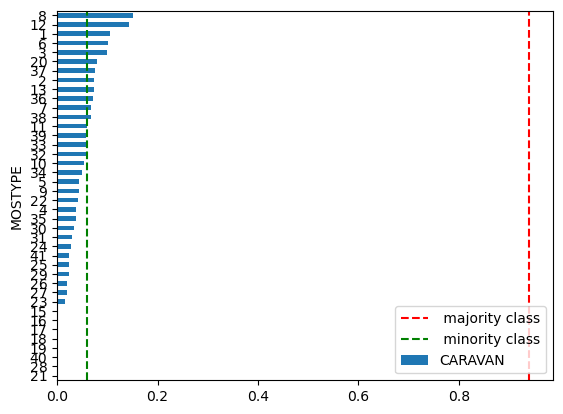

In [6]:
# Plot bar chart of `foundation_pivot`
pivot.plot(kind= "barh", legend = None)
plt.axvline(majority_class_prop, linestyle = "--", color ="red", label =" majority class")
plt.axvline(minority_class_prop, linestyle = "--", color ="green", label =" minority class")
plt.legend(loc= "lower right");

### Relationship among features

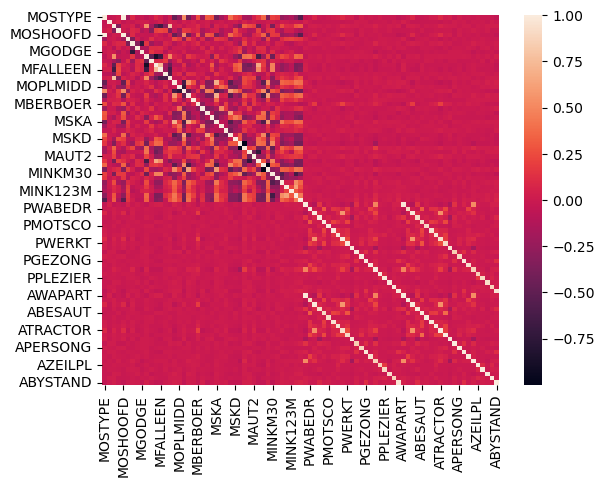

In [7]:
# Create correlation matrix
correlation = Train_df.drop(columns="CARAVAN").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

Since we have autocorrelation issues, this implies that we should steer clear of linear models, and try a tree-based model instead.

## Ensemble models : Random Forest Classifier

### Split Training Data into Train/Validation Sets

Create your feature matrix `X_train` and target vector `y_train`. The target is `"CARAVAN"`. 

In [8]:
# Split training data into features (X) and target (y)
target = "CARAVAN"
X_train = Train_df.drop(columns=target)
y_train = Train_df[target]

X_test = Validation_df         # Features only
y_test = Target_df['CARAVAN']  # Target only

# Build Model

## Baseline

Calculate the baseline accuracy score for your model.

In [9]:
acc_baseline = y_train.value_counts(normalize =True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.94


## Iterate

Create a pipeline named `model` that contains a `StandardScaler` transformer and a `RandomForestClassifier` predictor. Be sure you set the `class_weight` argument for your transformer to `balanced`. Then fit it to the training data. 

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Build model
model = make_pipeline(
        StandardScaler(),  
        RandomForestClassifier(class_weight='balanced', n_estimators=100))
#  Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

## Evaluate

Calculate the training and test accuracy scores for your models.

In [11]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.99
Test Accuracy: 0.93


# Communicate

Assign the feature names and importances of your model to the variables below. For the `features`, you can get them from the column names in your training set. For the `importances`, you access the [`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) attribute of the model's `RandomForestClassifier`. 

In [12]:
features = X_train.columns
importances = model.named_steps["randomforestclassifier"].feature_importances_

print("Features:", features[:6])
print("Importances:", importances[:6])

Features: Index(['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK'], dtype='object')
Importances: [0.03673687 0.00536916 0.00951509 0.00915022 0.02254969 0.01105624]


Create a pandas Series named `feat_imp`, where the index is `features` and the values are your `importances`. The Series should be sorted from smallest to largest importance.

In [16]:
feat_imp = pd.Series(importances, index = features).sort_values()
feat_imp.tail(6)

MINKM30     0.023980
MKOOPKLA    0.025462
MOSTYPE     0.036737
PBRAND      0.047141
APERSAUT    0.050418
PPERSAUT    0.065010
dtype: float64

Create a horizontal bar chart with all the features in `feat_imp`. Be sure to label your x-axis `"Gini Importance"`.

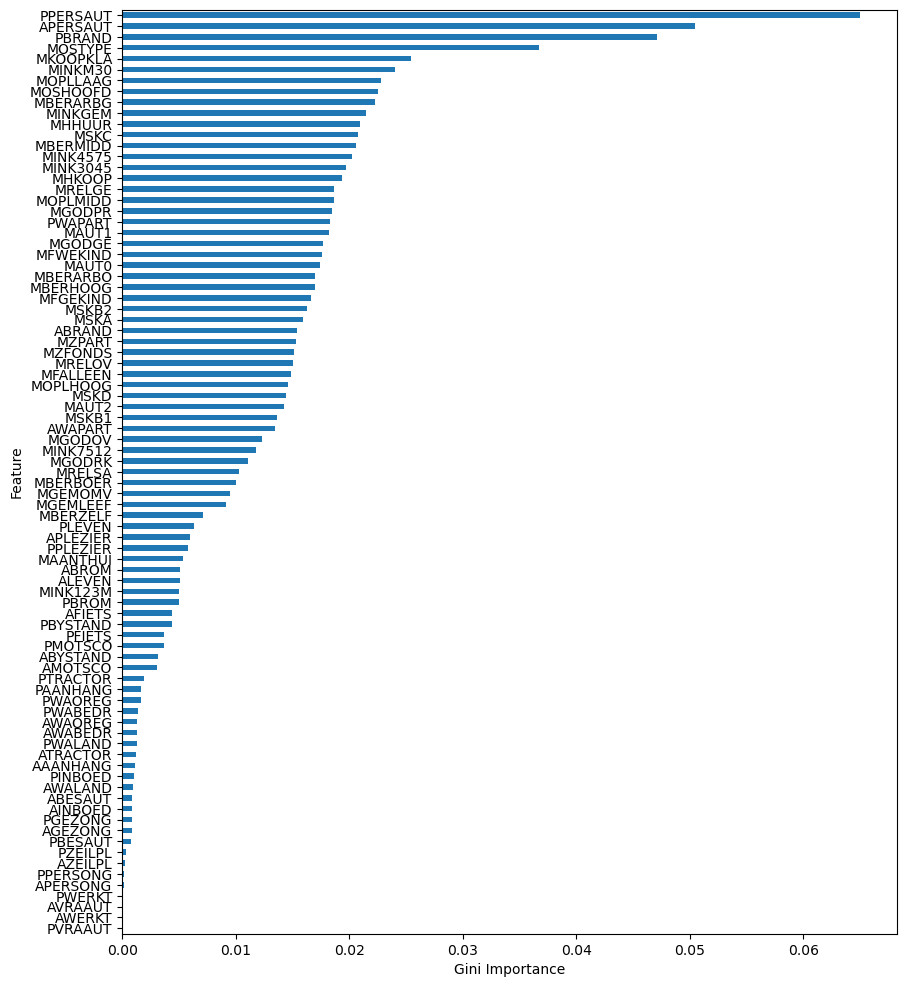

In [14]:
plt.figure(figsize=(10, 12))

# Create horizontal bar chart
feat_imp.plot(kind= "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

---
<center>
<table>
  <tr>
    <th>Date (YYYY-MM-DD)</th>
    <th>Author</th>
  </tr>
  <tr>
    <td>2025-03-17</td>
    <td>Andrew Kalumba Harris</td>
    <td> | andrewkalumbaharris@gmail.com</td>
  </tr>
</table>
</center>

